# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- modules..

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
from platform import python_version 
print(python_version())

3.8.8


Graphing settings

In [3]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#000000', #PV ICE baseline
              '#003f5c','#7a5195','#ef5675','#ffa600', #extreme cases (4)
              '#0e5c5c','#107575','#118f8f','#10aaaa','#0ec5c6','#09e2e2','#00ffff'] #realistic cases (7)
            #tealish ['#0e5c5c','#107575','#118f8f','#10aaaa','#0ec5c6','#09e2e2','#00ffff']
            #blues ['#004c6d','#00678a','#0083a6','#00a1c1','#00c0d8','#00dfed','#00ffff']
colormats = ['#00bfbf','#ff7f0e','#1f77be','#2ca02c','#d62728','#9467BD','#8C564B'] #colors for material plots       

import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['PV_ICE','50-year','High Eff','Idealized\nPerovskite\nSi-Tandem','Lightweight',
                    'PERC','SHJ','TOPCon','IRENA\nreg. loss','Recycled\nPERC','long-lived\nPERC','Hopeful\nPerovskite'] #

Scenarios and materials

In [4]:
#creating scenarios for identical power of multiple technologies, moved to below due to reordering
scennames_ex = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'ex_Lightweight'] #extreme cases
scennames_r = ['PV_ICE','r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'r_RecycledPERC', 'r_50PERC', 'r_Perovskite'] #realistic cases

MATERIALS = ['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [5]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames_ex:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [6]:
PV_ICE.__version__

'v0.2.0+415.gfda9bbf.dirty'

## Module Types Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [7]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'ex_Lightweight'])

In [8]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [9]:
celltech_modeff.loc[2020]

PERC      22.8
SHJ       23.5
TOPCon    23.2
Name: 2020, dtype: float64

In [10]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [11]:
timeshift = 2022-1995

## Extreme modules

### PERC_50
This module represents current PERC technology (so good efficiency) if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. It is assumed that this module is no more recyclable than current technology (downcycle glass and recycle aluminium frames).

In [12]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_PERC_50', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [13]:
#silver modify for PERC
sim1.scenario['ex_PERC_50'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [14]:
#modify package to glass glass
sim1.scenario['ex_PERC_50'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #

In [15]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_PERC_50', 'mod_degradation', 0.445, start_year=2022) #annual power degradation to reach 80% at 50 yrs
#T50
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [16]:
#Merchant Tail set high
sim1.modifyScenario('ex_PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail
#Change recycling?

### High Efficiency
This represents a 25 year lifetime module where efficiency has been prioritized. This could represent a silicon based tandem, along the lines of SHJ 

In [17]:
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_higheff = pd.DataFrame(index=idx_temp, columns=['mod_eff_p'], dtype=float)
df_higheff.loc[2022] = 22.0
df_higheff.loc[2030] = 25.0
df_higheff.loc[2050] = 30.0
df_higheff.interpolate(inplace=True)
#module efficiency modify for PERC
sim1.modifyScenario('ex_High_eff', 'mod_eff', df_higheff.loc[2022:,], start_year=2022) #changing module eff

In [18]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_High_eff', 'mod_degradation', 0.7, start_year=2022) #standard current degrdation
#T50
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t50', 25, start_year=2022)
#t90
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t90', 31, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_High_eff', 'mod_lifetime', 25, start_year=2022) #project lifetime of 25 years

### Idealized Perovskite
This perovskite module uses current best module and cell efficiencies, has a prospective life of 15 years and 1.5% degradation rate, and is highly circular. This is a best case scenario for perovskites given current data.

In [19]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 27.3% # Sofia et al 2019 4T future
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9
df_perovskite_eff.loc[2030] = 27.3
df_perovskite_eff.loc[2050] = 27.3
df_perovskite_eff.interpolate(inplace=True)

In [20]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Perovskite', 'mod_eff', df_perovskite_eff['mod_eff_p'], start_year=2022) #changing module eff

In [21]:
#modify package to glass glass
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [22]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Perovskite', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Perovskite', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t50', 14, start_year=2022)
#t90
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t90', 20, start_year=2022) 

In [23]:
#As Circular as possible
#100% collection rate
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #99% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send none to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_ReMFG_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild


#silicon ReMFG 
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 0.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


#aluminium_frames recycle
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild


### Lightweighting
- 10% Si
- 50% encapsulant
- 2mm glass
- frameless
- possibly reduced reliability

Could represent a thin film

In [24]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Lightweight', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [25]:
#2mm glass calculation
lightweightglass = (2.0/1000)* 1 * density_glass

#50% encapsulant
light_encap = pd.Series(sim1.scenario['PV_ICE'].material['encapsulant'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.5)

#10% silicon
light_Si = pd.Series(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.1)

#modify BOM
sim1.scenario['ex_Lightweight'].modifyMaterials('glass', 'mat_massperm2', lightweightglass, start_year=2022) #glass
sim1.scenario['ex_Lightweight'].modifyMaterials('aluminium_frames', 'mat_massperm2', 0.0, start_year=2022) #frameless
sim1.scenario['ex_Lightweight'].modifyMaterials('encapsulant', 'mat_massperm2', light_encap, start_year=2022) #50% encapsulant
sim1.scenario['ex_Lightweight'].modifyMaterials('silicon', 'mat_massperm2', light_Si, start_year=2022) #10% silicon


In [26]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Lightweight', 'mod_degradation', 0.7, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Lightweight', 'mod_lifetime', 25, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t50', 25, start_year=2022) #this will get changed with IRENA alpha/b
#t90
sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t90', 31, start_year=2022) #this will get changed with IRENA alpha/b

In [27]:
len(sim1.scenario['ex_Lightweight'].material['silicon'].matdataIn_m)

56

## Evolving Realistic Modules

For these more realisitic evolving modules, some module and material input files have been modified and are stored in the baselines\Energy_CellModuleTechCompare folder.

In [28]:
altBaselinesfolder

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\PV_ICE\\baselines\\Energy_CellModuleTechCompare'

Improving recycling:
- 2022: 15% collection, 75% recycled module, 100% downcycled glass, 100% HQ al frames, 20% closed loop
- 2030: 30% collection, 80% recycled module, 30% closed-loop glass, 30% closed-loop silicon, 30% closed-loop silver, 50% closed loop Al frames
- 2050: 75% collection, 95% recycled module, 75% closed loop recycled glass, 75% closed loop recycled silicon, 75% closed-loop silver, 100% closed loop al frames

### PERC

In [29]:
#modified module
moduleinput_m_r_PERC = os.path.join(altBaselinesfolder, 'mod_r_PERC.csv')
sim1.createScenario(name='r_PERC', massmodulefile=moduleinput_m_r_PERC, energymodulefile=moduleFile_e) 

In [30]:
#module efficiency modify for PERC
sim1.modifyScenario('r_PERC', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [31]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_PERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_PERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_PERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_PERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_PERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [32]:
#modify silver usage for PERC
sim1.scenario['r_PERC'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)

In [33]:
#modify package to glass glass
sim1.scenario['r_PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

### SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [34]:
#modified module
moduleinput_m_r_SHJ = os.path.join(altBaselinesfolder, 'mod_r_SHJ.csv')
sim1.createScenario(name='r_SHJ', massmodulefile=moduleinput_m_r_SHJ, energymodulefile=moduleFile_e) 

In [35]:
#module efficiency modify for SHJ
sim1.modifyScenario('r_SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [36]:
#load modified materials
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_SHJ'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_SHJ'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_SHJ'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_SHJ'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_SHJ'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [37]:
#modify silver usage for SHJ
sim1.scenario['r_SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [38]:
#modify package to glass glass
sim1.scenario['r_SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [39]:
#Merchant Tail set high
#sim1.modifyScenario('SHJ', 'mod_MerchantTail', 50, start_year=2022) #50% stay for merchant tail, possibly change to DYNAMIC


Text(0.5, 1.0, 'Silicon Management Evolution')

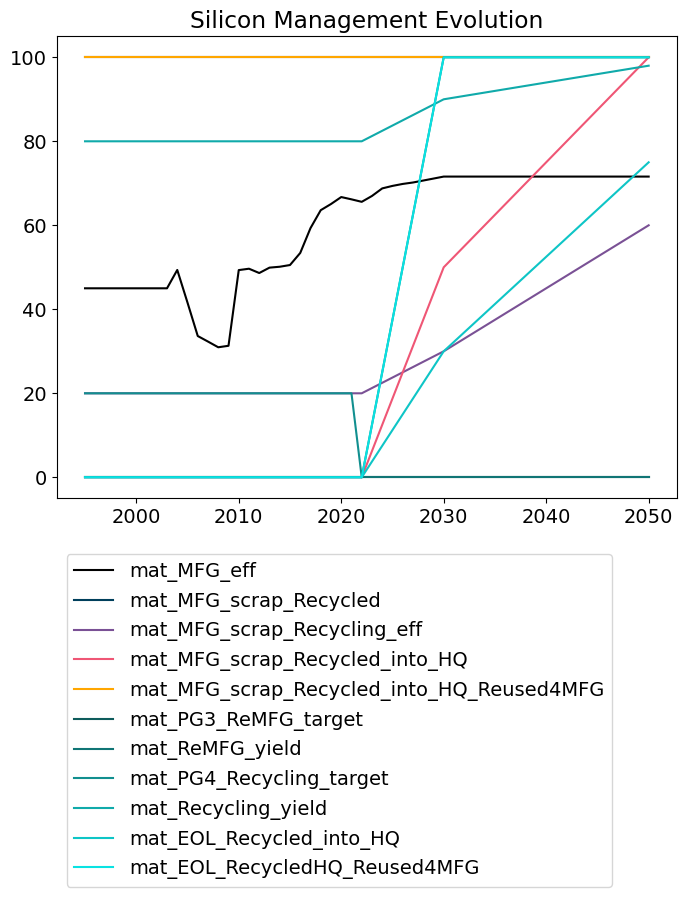

In [40]:
plt.plot(sim1.scenario['r_SHJ'].material['silicon'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['silicon'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Silicon Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

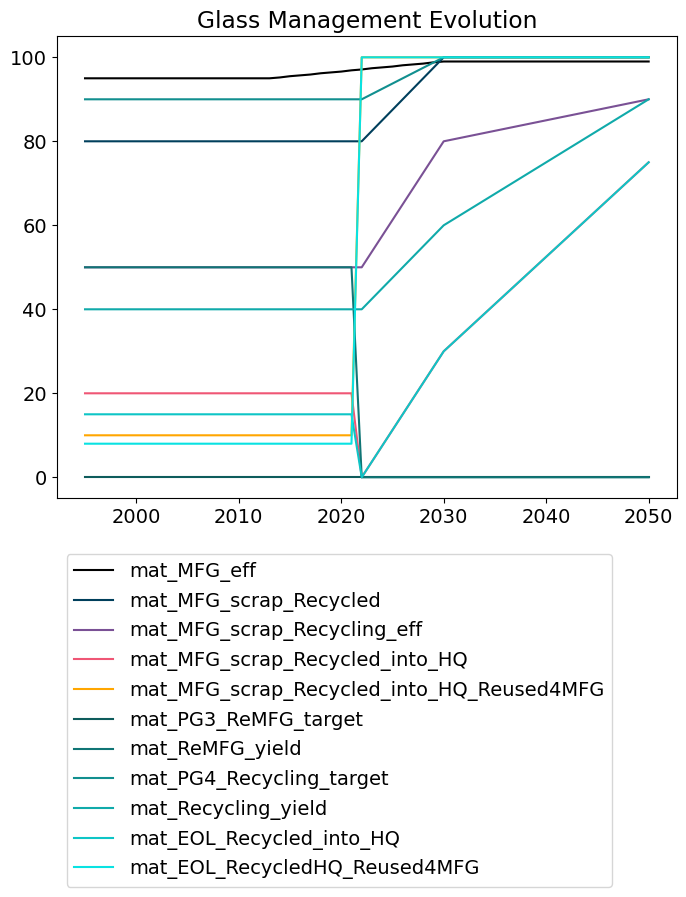

In [41]:
plt.plot(sim1.scenario['r_SHJ'].material['glass'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['glass'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['glass'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

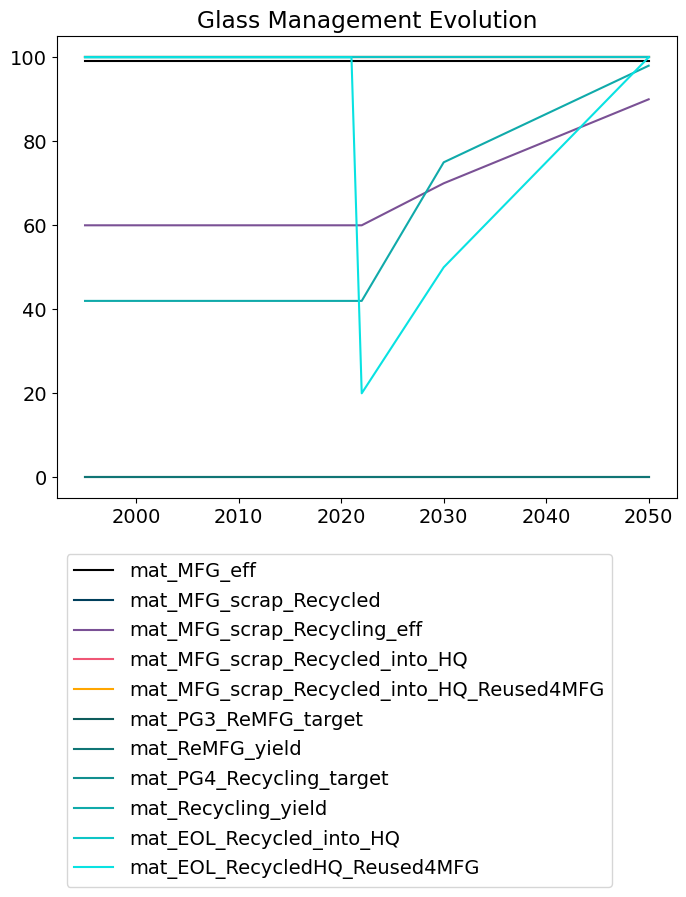

In [42]:
plt.plot(sim1.scenario['r_SHJ'].material['aluminium_frames'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['aluminium_frames'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['aluminium_frames'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

Text(0.5, 1.0, 'Glass Management Evolution')

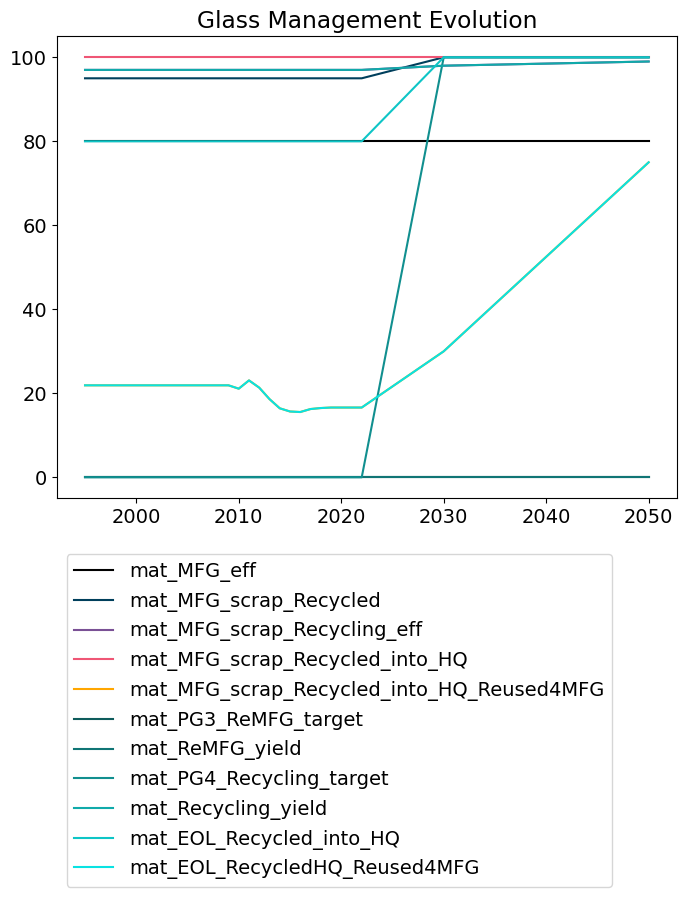

In [43]:
plt.plot(sim1.scenario['r_SHJ'].material['silver'].matdataIn_m.iloc[:,0],sim1.scenario['r_SHJ'].material['silver'].matdataIn_m.iloc[:,3:])
plt.legend(sim1.scenario['PV_ICE'].material['aluminium_frames'].matdataIn_m.iloc[:,3:].columns, 
           bbox_to_anchor=(0, -0.1), loc='upper left', ncol=1)
plt.title('Glass Management Evolution')

### TOPCon

In [44]:
#modified module
moduleinput_m_r_TOPCon = os.path.join(altBaselinesfolder, 'mod_r_TOPCon.csv')
sim1.createScenario(name='r_TOPCon', massmodulefile=moduleinput_m_r_TOPCon, energymodulefile=moduleFile_e) 

In [45]:
#module efficiency modify
sim1.modifyScenario('r_TOPCon', 'mod_eff', celltech_modeff.loc[2022:,'TOPCon'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [46]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_TOPCon'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_TOPCon'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_TOPCon'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_TOPCon'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_TOPCon'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [47]:
#modify silver usage for PERC
sim1.scenario['r_TOPCon'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'TOPCon'], start_year=2022)

In [48]:
#modify package to glass glass
sim1.scenario['r_TOPCon'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

### IRENA Reg. Loss with improved recycling
This scenario uses the IRENA 2016 regular loss scenario results, or a low quality module, and assumes the same EoL recycling improvement as the previous three scenarios

In [49]:
#modified module
moduleinput_m_r_IRENA = os.path.join(altBaselinesfolder, 'mod_r_IRENAregloss.csv')
sim1.createScenario(name='r_IRENA', massmodulefile=moduleinput_m_r_IRENA, energymodulefile=moduleFile_e) 

In [50]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_IRENA'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_IRENA'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_IRENA'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_IRENA'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_IRENA'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

### Recycled PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html

In [51]:
#modified module
moduleinput_m_r_RecyclePERC = os.path.join(altBaselinesfolder, 'mod_r_PERCrecycleSi.csv')
sim1.createScenario(name='r_RecycledPERC', massmodulefile=moduleinput_m_r_RecyclePERC, energymodulefile=moduleFile_e) 

for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['r_RecycledPERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [52]:
#glass recycling
#eol
sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
#sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 0.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 0.0, start_year=2022) #closed-loop

#silicon recycled
#mfg scrap
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#aluminium_frames recycle
#mfg scrap
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#silver recycling improvement
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_silver_recycleimprove = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_silver_recycleimprove.loc[2022] = 0
df_silver_recycleimprove.loc[2030] = 40
df_silver_recycleimprove.loc[2050] = 100
df_silver_recycleimprove.interpolate(inplace=True)

#eol
sim1.scenario['r_RecycledPERC'].modifyMaterials('silver', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_RecycledPERC'].modifyMaterials('silver', 'mat_PG4_Recycling_target',
                                                df_silver_recycleimprove.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) 
sim1.scenario['r_RecycledPERC'].modifyMaterials('silver', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [53]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)
altHQRecycle_e

,E_MFG_kWhpkg,E_mfgFuelFraction
1995,600.817735,0.064489
1996,527.042434,0.072326
1997,485.167804,0.077357
1998,432.693843,0.085473
1999,380.620553,0.095834
2000,269.697933,0.075408
2001,236.759317,0.066235
2002,204.221370,0.054188
2003,172.084094,0.037719
2004,159.669155,0.030097


In [54]:
#modify silicon recycling energy
sim1.scenario['r_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['r_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [55]:
sim1.scenario['r_RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

,year,e_mat_extraction,e_mat_MFG,e_mat_MFG_fuelfraction,e_mat_MFGScrap_LQ,e_mat_MFGScrap_HQ,e_mat_Landfill,e_mat_Landfill_fuelfraction,e_mat_EoL_ReMFG_clean,e_mat_Recycled_LQ,e_mat_Recycled_HQ,e_mat_Recycled_HQ_fuelfraction
25,2020,0.0062,169.06,0.22,24.5,600.0,0.09,0.0,0.4,1.6,138.380000,0.200000
26,2021,0.0062,170.73,0.21,24.5,600.0,0.09,0.0,0.4,1.6,143.040000,0.190000
27,2022,0.0062,169.05,0.20,24.5,600.0,0.09,0.0,0.4,1.6,77.837724,0.055738
28,2023,0.0062,168.80,0.20,24.5,600.0,0.09,0.0,0.4,1.6,77.837724,0.055738
29,2024,0.0062,169.09,0.20,24.5,600.0,0.09,0.0,0.4,1.6,77.837724,0.055738


### 50-year PERC gradual improvement

In [56]:
#modified module
moduleinput_m_r_50PERC = os.path.join(altBaselinesfolder, 'mod_r_50PERC.csv')
sim1.createScenario(name='r_50PERC', massmodulefile=moduleinput_m_r_50PERC, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['r_50PERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [57]:
#glass recycling
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_glass_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_glass_target.loc[2022] = 0
df_glass_target.loc[2030] = 100
df_glass_target.loc[2050] = 100
df_glass_target.interpolate(inplace=True)

df_glass_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_glass_lowrecycle.loc[2022] = 0
df_glass_lowrecycle.loc[2030] = 0
df_glass_lowrecycle.loc[2050] = 50
df_glass_lowrecycle.interpolate(inplace=True)

#eol
sim1.scenario['r_50PERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_50PERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 
                                          df_glass_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
#sim1.scenario['r_RecycledPERC'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_50PERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 
                                          df_glass_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['r_50PERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [58]:
#silicon recycled
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_si_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_si_target.loc[2022] = 0
df_si_target.loc[2030] = 0
df_si_target.loc[2050] = 50
df_si_target.interpolate(inplace=True)

#eol
sim1.scenario['r_50PERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_50PERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 
                                          df_si_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
#sim1.scenario['r_50PERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_50PERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_50PERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



In [59]:
#sim1.scenario['r_50PERC'].material['silicon'].matdataIn_m

In [60]:
#aluminium_frames recycle
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_al_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_al_target.loc[2022] = 0
df_al_target.loc[2030] = 100
df_al_target.loc[2050] = 100
df_al_target.interpolate(inplace=True)

df_al_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_al_lowrecycle.loc[2022] = 0
df_al_lowrecycle.loc[2030] = 100
df_al_lowrecycle.loc[2050] = 100
df_al_lowrecycle.interpolate(inplace=True)

df_al_lowCL = pd.DataFrame(index=idx_temp, columns=['mat_EOL_RecycledHQ_Reused4MFG'], dtype=float)
df_al_lowCL.loc[2022] = 0
df_al_lowCL.loc[2030] = 20
df_al_lowCL.loc[2050] = 50
df_al_lowCL.interpolate(inplace=True)

#eol
sim1.scenario['r_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 
                                          df_al_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
sim1.scenario['r_50PERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 
                                          df_al_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['r_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 
                                          df_al_lowCL.loc[2022:,'mat_EOL_RecycledHQ_Reused4MFG'], start_year=2022) #closed-loop


In [61]:
#sim1.scenario['r_50PERC'].material['aluminium_frames'].matdataIn_m

### Hopeful Perovskite, Gradually increasing circularity

In [62]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite.csv')
sim1.createScenario(name='r_Perovskite', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_Perovskite'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_Perovskite'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['r_Perovskite'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [63]:
#aluminium_frames recycle
#eol
sim1.scenario['r_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['r_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['r_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['r_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['r_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


### Modify Years 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [64]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Trimming and extending  PV_ICE
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE : Data trimmed for Mass, years now encompass  2000  to  2100
Trimming and extending  ex_PERC_50
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PER

In [65]:
#check
sim1.scenario['r_Perovskite'].dataIn_m

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled
0,2000,20.926667,13.420000,19.0,23.0,0.75,20.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
1,2001,27.985000,13.600000,19.0,23.0,0.75,20.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
2,2002,42.476000,13.722222,19.0,23.0,0.75,20.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
3,2003,59.745000,13.844444,19.0,23.0,0.75,20.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
4,2004,94.752000,13.966667,19.0,23.0,0.75,20.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2096,0.000000,27.300000,29.0,32.0,0.50,25.0,98.0,0.0,0.0,...,0.0,0.0,100.0,0.0,98.0,100.0,0.0,0.0,100.0,0.0
97,2097,0.000000,27.300000,29.0,32.0,0.50,25.0,98.0,0.0,0.0,...,0.0,0.0,100.0,0.0,98.0,100.0,0.0,0.0,100.0,0.0
98,2098,0.000000,27.300000,29.0,32.0,0.50,25.0,98.0,0.0,0.0,...,0.0,0.0,100.0,0.0,98.0,100.0,0.0,0.0,100.0,0.0
99,2099,0.000000,27.300000,29.0,32.0,0.50,25.0,98.0,0.0,0.0,...,0.0,0.0,100.0,0.0,98.0,100.0,0.0,0.0,100.0,0.0


### Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 75 TW in 2050, and from 2050 to 2100 is a linear increase to 86 TW based on 2000-2021 global increase in electricity capacity.

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

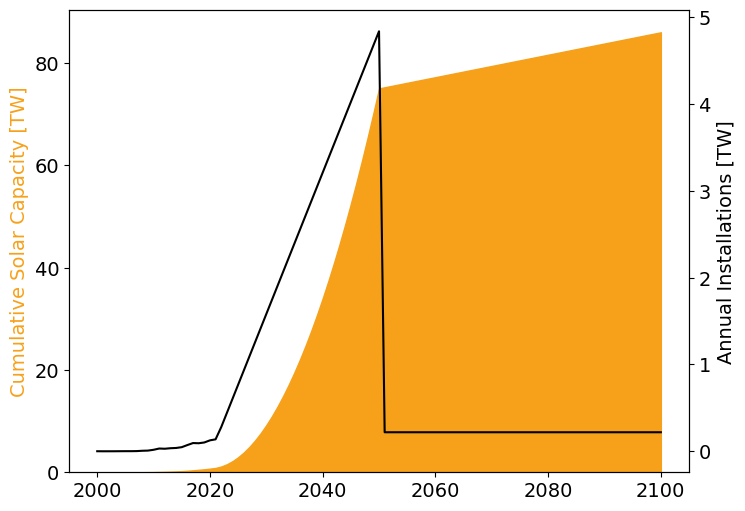

In [66]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.stackplot(global_projection.index, global_projection['World_cum']/1e6, color='#F7A11A')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='#F7A11A')
ax1.ylim(0,90)
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
ax2.ylim(0,5)
plt.show()
plt.xlim(2000,2100)


In [67]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# Calculate Mass flow
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [68]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'ex_Lightweight', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'r_RecycledPERC', 'r_50PERC', 'r_Perovskite'])

In [69]:
scennames_ex = ['ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'ex_Lightweight'] #extreme cases
scennames_r = ['r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'r_RecycledPERC', 'r_50PERC', 'r_Perovskite'] #realistic cases
scennames_all = ['ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'ex_Lightweight',
                 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'r_RecycledPERC', 'r_50PERC', 'r_Perovskite']

In [70]:
for scen in sim1.scenario.keys():
    print(sim1.scenario[scen].material.keys())

dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])


In [71]:
IRENAregloss = {'alpha':5.692,
                   'beta':29.697}

idx_temp = pd.RangeIndex(start=2022,stop=2101,step=1) #create the index
evolve_weibull = pd.DataFrame(index=idx_temp, columns=['alpha','beta'], dtype=float)
evolve_weibull.loc[2022] = [5.3759,30]
evolve_weibull.loc[2030] = [5.1   ,35]
evolve_weibull.loc[2050] = [4.602 ,40.767]

evolve_weibull.interpolate(inplace=True)
evolve_weibull = round(evolve_weibull,3)
#evolve_weibull_temp = evolve_weibull.reset_index(drop=True)
#evolve_weibull_temp.to_dict(orient='dict')
#dict([(i,[a,b,c ]) for i, a,b,c in zip(df.ID, df.A,df.B,df.C)])
dict_weibull = {'alpha':evolve_weibull['alpha'].tolist(),
                'beta':evolve_weibull['beta'].tolist()}
evolve_weibull.to_csv(os.path.join(altBaselinesfolder,'evolve_weibull.csv'))

In [72]:
sim1.calculateMassFlow()

>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working o

Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


In [73]:
sim1.calculateMassFlow(scenarios=['ex_Lightweight','r_IRENA'], weibullInputParams=IRENAregloss)
#need to create an upgrade to weibull params to account for evolving params
#dict_weibull # evolve_weibull
#sim1.calculateMassFlow(scenarios=['r_IRENA'])

>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757850.2752181168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working o

In [74]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [75]:
sim1.scenario['r_IRENA'].dataOut_m['WeibullParams']

0      {'alpha': 5.692, 'beta': 29.697}
1      {'alpha': 5.692, 'beta': 29.697}
2      {'alpha': 5.692, 'beta': 29.697}
3      {'alpha': 5.692, 'beta': 29.697}
4      {'alpha': 5.692, 'beta': 29.697}
                     ...               
96     {'alpha': 5.692, 'beta': 29.697}
97     {'alpha': 5.692, 'beta': 29.697}
98     {'alpha': 5.692, 'beta': 29.697}
99     {'alpha': 5.692, 'beta': 29.697}
100    {'alpha': 5.692, 'beta': 29.697}
Name: WeibullParams, Length: 101, dtype: object

(0.0, 90.26425956655)

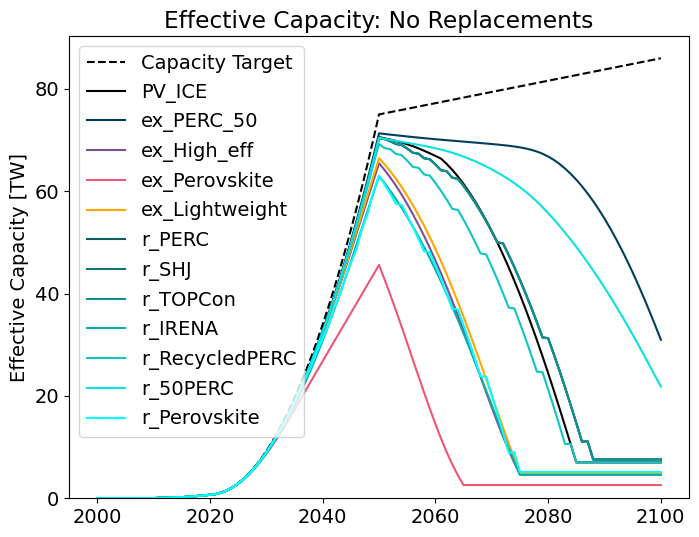

In [76]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

(0.0, 90.26425956655)

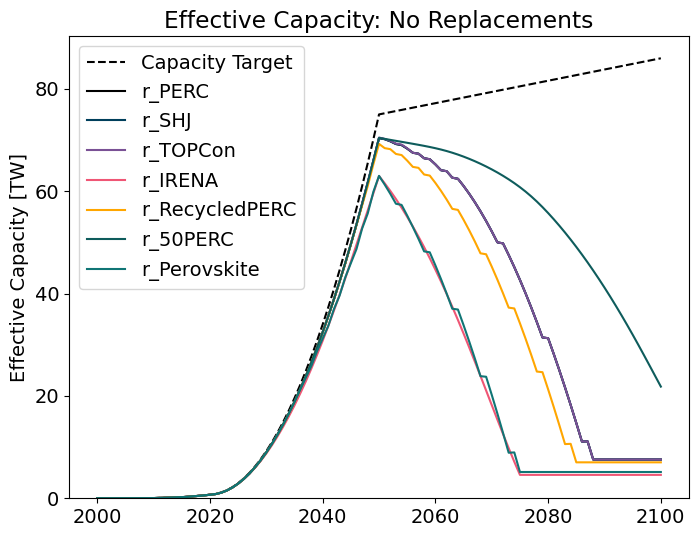

In [77]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity').filter(like='r_')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=scennames_r)
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

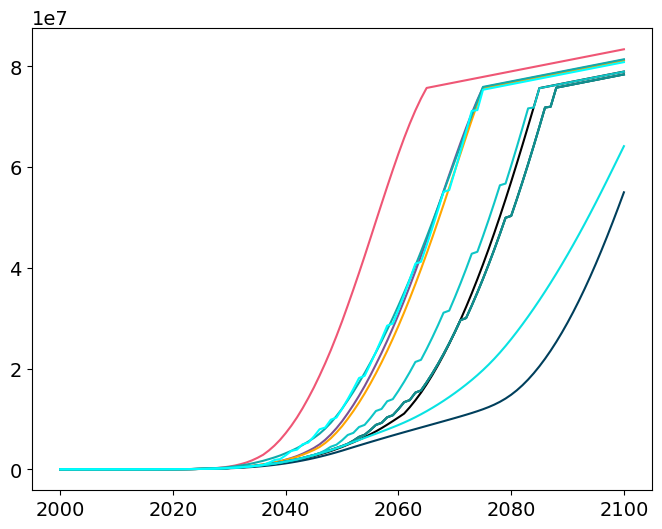

In [78]:
plt.plot(ii_yearly.filter(like='Decommisioned'))

(0.0, 90.26425956655)

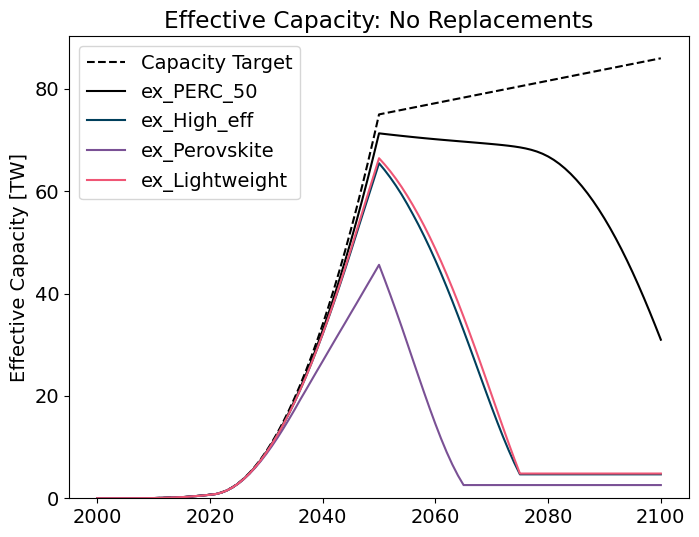

In [79]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity').filter(like='ex_')
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=scennames_ex)
plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

# Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. (i.e. not the PV ICE baseline)

#### Bifacial Factors

In [80]:
bifiFactors = {'ex_PERC_50':0.7, # ITRPV 2022, Fig. 58
               'ex_High_eff': 0.9,
               'ex_Perovskite': 0.0,
               'ex_Lightweight':0.0,
               'r_PERC':0.7,
               'r_SHJ':0.9, # ITRPV 2022, Fig. 58
               'r_TOPCon':0.8, # ITRPV 2022, Fig. 58
               'r_Perovskite':0.0,
               'r_RecycledPERC':0.6,
                'PV_ICE':0.0,
                'r_IRENA':0.0,
                'r_50PERC':0.7} 

#MAY NEED TO CHANGE TO BE DYNAMIC

In [81]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [ ]:
#currently takes ~40 mins to run with 7 materials and 12 scenarios

for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in sim1.scenario.keys(): #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        #calculate flows for that scenario with it's bifi factor and modified weibull
        if scen in ['r_IRENA','ex_Lightweight']:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
        else:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757850.2752181168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757850.2752181168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757853.5381127008  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757857.830439547  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757863.5869331358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757871.9983089576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757884.3696439145  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757900.7069253485  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757923.1651702179  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  757961.3816403319  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  758019.9347410958  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  758119.6847351692  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  758294.561188773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  758490.5238801029  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  758746.1403342065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  759041.3095177815  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  759386.5821193631  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2261270463.402664  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387049.041131277  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64769364.17087526  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227616117.55816853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  759828.8736913154  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373192855.9668417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41337607.30581384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264872.1093434672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213286769.42812976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308942343.0269725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39467967.95317643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425401.42431720375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203544900.08414796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1595693816.518033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53257746.26987195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  539701.919030479  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266242306.80983013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42815791751.684364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547553467.963103  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8978689.163278334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099250202.386619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97481439.30673648  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  573856.2165622875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333683224.3069309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029022.147874344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927927.0189553685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431566.71094267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2368886196.8790827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55794628.10557675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2119628.378574106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283498119.0657594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2262906038.645877  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11387842.128228802  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64849839.88450026  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  227888275.48103756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  768303.4291314336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1373897080.3661873  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41375337.49150039  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265298.3064031323  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213464371.54929227  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1309633645.8777058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39505005.84187788  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  425819.8012473337  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203719243.45079342  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1598080060.103006  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53393931.778362766  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  541146.0751836946  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  266844106.35368934  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42816700244.97547  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547602142.250163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8979205.321509415  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099465292.553518  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97558909.18893237  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  574669.4346597868  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  333939977.06435513  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2370521772.1223016  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55853753.11966857  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2121293.532032201  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283770276.9886285  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2264295684.1691375  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11388515.964507006  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64914763.84351265  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  228109628.84757107  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  775906.8305503794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1374489921.597595  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41405496.90760192  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  265633.0087686958  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213607493.7898396  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1310215609.2883554  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39534611.87419773  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  426148.362285089  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203859739.5951842  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1601106130.5914254  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53557915.907183744  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  542854.5139649047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  267574652.68787336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42817572103.114426  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547646496.001219  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8979667.412987053  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099662887.713941  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97621408.18682654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  575313.9919715587  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  334148800.9950465  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2371911417.6455617  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406205937  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  55901452.35486145  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2122636.8982478436  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  283991630.3551614  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2267656165.5701175  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11390145.455080474  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65062857.094524086  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  228622965.14641255  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  779848.2213976285  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376028668.713771  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41479335.70065734  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  266322.7402991584  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213947745.3953423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1311726122.5124898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39607095.82701359  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  426825.4381911389  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204193748.05196178  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1605248390.476934  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53756958.60053156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  544682.0151053987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  268476177.6575865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42818001968.103  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547667123.6349623  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8979856.80463744  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099756316.548593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97763970.0380119  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  576609.6954484334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  334633080.52225626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2375271899.0465364  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56010255.55968594  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2125701.1517714746  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  284504966.6540033  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1377770709.9739313  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41558798.772450395  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267023.5019428105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214299900.97606027  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313436199.7128325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39685100.86079213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427513.34182298096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204539442.06239164  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1609676255.5584311  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53959114.17358802  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546436.3867602423  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269357806.63158023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42818475618.1459  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547688729.1435237  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8980044.304250918  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7099850541.219514  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97917113.52661091  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  577925.299797608  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335133990.7915823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1377770709.9739313  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41558798.772450395  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267069.31856297905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214323531.08166647  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313436199.7128325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39685100.86079213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427609.3822061706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204561938.60909712  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1609676255.5584311  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53964044.87990538  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546506.6614995823  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269379203.97440463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42824261328.868706  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1547940221.7949684  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8982089.570826193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7100941921.264161  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97917113.52661091  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  577925.299797608  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335133990.7915823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1377770709.9739313  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41558798.772450395  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267128.22009853204  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214354770.33461484  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313436199.7128325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39685100.86079213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427730.6235666035  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204591673.45756307  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1609676255.5584311  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53970594.71155674  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546597.977575681  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269407834.4994984  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42834131074.937035  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1548351198.665226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8985299.230295384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7102738377.146264  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97917113.52661091  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  577925.299797608  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335133990.7915823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1378057246.0956602  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41567925.64682092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267205.64000690327  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214397322.20710826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1313708884.3130143  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39693786.53041595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427886.775522421  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204632168.3182732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1609945985.3470767  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53979635.83369027  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546721.0741332273  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269447890.55771846  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42850552839.31348  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1549006521.2566552  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8990174.67913482  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7105641737.977749  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97917113.52661091  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  577925.299797608  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335133990.7915823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75536643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1378454188.2797253  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41580367.89272951  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267304.88853948086  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214453978.10035223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1314086565.9357712  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39705625.04951057  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428082.4303301964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204686075.13533157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1610323732.223982  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  53991754.12298683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  546880.3412055696  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269501806.68855655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42875125197.97091  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1549975092.6167831  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  8997089.4973921  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7109951060.762571  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97944287.9293974  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  578117.3434850438  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335224668.1112247  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431868.75681054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1378982179.8430383  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41596650.11251604  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267428.54810623976  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214527770.7322153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1314588843.9185717  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39721114.31312413  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428319.9733255795  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204756274.01132336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1610822518.8591297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54007292.26400638  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547076.9713648016  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269571517.6102893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42909447677.72236  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1551311301.3577285  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9006245.584936965  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7115945879.759346  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  97979783.02579914  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  578358.1093251472  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335344103.0496148  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27431873.78028939  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1379642669.0005467  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41616705.62761821  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267574.07065337664  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214618805.46523088  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1315217050.6418614  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39740189.583751954  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428591.353447832  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204842859.280261  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1611431746.5287642  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54025869.8427044  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547302.4437123082  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269655487.01027167  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  42953930865.17096  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1552998278.292517  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9017328.476387396  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7123570901.475092  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98023204.05399378  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  578640.4899657811  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335491298.13394433  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.584436378  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27432301.789000288  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1380494787.1912222  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41642176.504283495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267750.7064438896  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214735009.36385056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1316027372.5804148  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39764411.11825492  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  428909.67044392583  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204953363.39744493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1612244672.2157838  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54050210.498270616  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547584.8566158195  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269766346.2022869  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43012489173.07663  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1555161719.835792  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9030892.512000253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7133424267.207469  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98077853.18728349  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  578979.66034434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335677972.19694406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.5844364064  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27437037.884504493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1381576558.0737803  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41673999.88625473  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  267961.2300006581  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214881178.31264004  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1317055898.0275428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39794668.13357936  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  429274.1680714467  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205092337.8196945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1613301715.7359462  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54081326.62522461  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  547928.722242129  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269909173.98833483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43087087491.69809  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1557846742.504596  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9046898.340491237  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7145748932.286793  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98145464.24098559  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  579378.629009523  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  335910731.01185656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927980.594393512  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27454436.378549196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1382916430.2740297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41713144.22042809  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  268205.1834713311  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215060663.82655153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1318329595.3017037  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39831879.16887525  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  429676.95019100845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205262958.72650775  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1614582901.7261598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54118765.25864453  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  548317.5028149232  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270080798.06250167  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43176315820.36997  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1561050491.2303457  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9064812.08483241  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7160435376.707796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98227801.97280967  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  579834.3695947427  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  336193817.00557077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2927991.392269374  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27490136.089358523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2379069480.7893915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56127134.67018479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2128992.8491692  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285035931.5394898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1384366345.9425998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41755209.3104189  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  268465.2032249485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215253260.9138709  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1319707901.1091359  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39871866.7068275  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  430108.57561977574  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205446043.63944525  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1615936099.1311154  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54158028.629145354  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  548724.193868091  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270260547.74340534  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43275640278.75861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1564608031.2098525  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9084843.155788753  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7176721973.297996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98315790.07410234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  580324.7907625906  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  336495927.46365696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2928224.267319465  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27541197.847423423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2381211764.923773  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56178906.49938842  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2130450.9129304457  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285282821.15686864  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1386336481.4312272  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41812367.066845514  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  268813.14682110137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215514944.72101808  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1321580733.6084788  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39926201.49976087  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  430689.3477791713  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205694803.14933982  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1617840030.2532747  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54213268.345324904  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  549290.8958972463  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270513437.93672884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43400150267.624275  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1569067650.4257393  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9109953.470631672  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7197138333.910512  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98434679.31833075  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  580987.446293764  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  336904138.1592814  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2929863.4684227225  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27610545.49513348  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2384219088.118478  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56251583.42412387  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2132497.732443404  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285629403.0415771  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1388318379.2944362  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41869866.07439176  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  269157.7781127839  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  215778183.554003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1323464747.5506778  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39980860.689767934  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  431267.85522790113  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205945040.88392663  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1619688716.0190156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54266903.70962301  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  549835.8254390759  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  270758983.3266116  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43532393490.52516  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1573804253.6765523  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9136623.370718699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7218822741.337607  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98553612.18837453  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  581650.3449830806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  337312498.6457852  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311893415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2935160.1887553427  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27694442.002265092  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2387326967.3635764  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56326690.45165607  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2134612.9915861473  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  285987573.6060543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1391030198.5591152  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41948541.63041226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  269621.9680752071  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216138367.2817233  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1326042632.81824  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40055650.54004453  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  432051.59294353245  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206287435.5034352  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1622368066.2619925  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54344637.93675626  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  550617.8959266448  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  271114854.52015066  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43697126858.2147  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1579704568.1713095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9169845.658870066  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7245834677.249774  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98715445.9746079  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  582552.3614293478  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  337868161.04302394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.311929598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2946745.8304866455  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27797495.548624694  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2391657965.901784  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56431356.17409816  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2137560.720095741  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  286486703.74234456  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2271453747.3129663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11391986.894717675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65221942.55048083  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229153930.0318992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1394003778.0652401  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42034811.399221234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  270122.88991760934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216533315.9359966  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1328869350.2549832  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40137659.53265892  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  432902.40122221556  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206662878.04511032  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1625153803.096631  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54425458.26691449  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  551423.0085134354  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  271484854.04823923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  43878408547.65755  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1586197599.879794  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9206405.298290465  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7275560102.316713  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98891927.9491566  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  583536.0227970862  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  338474118.546272  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029294.660479262  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2965429.601023856  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  27916592.72458824  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2396542693.687597  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56549403.6770296  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2140885.323239522  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  287049648.944003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2285972565.8435726  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399027.040193673  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  65608778.46689389  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  230509252.15575558  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1396901986.4225323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42118894.493158616  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  270603.2467782539  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216918253.038599  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1331624419.047325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40217589.84805105  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  433723.28396685404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  207028803.4954755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1627835845.3333404  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54503270.025650784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  552190.4418454525  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  271841080.18534863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44065007924.45766  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1592881097.1158938  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9244037.372179726  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7306157488.129126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  99063010.50281113  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  584489.5892967492  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  339061536.9346197  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9029401.541264761  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  2990755.8935590116  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  28050220.895681236  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2401546700.3238487  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  56670333.75009888  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2144291.108970861  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  287626340.55271995  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2309454060.652688  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11410413.169106197  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  66234413.77902925  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  232701234.19264957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1400739449.2595692  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42230227.326561  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  271228.8610016011  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217427940.55948427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1335272353.4953403  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40323424.06597334  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  434799.13120707334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  207513318.0677643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1631461012.0500696  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54608443.74969919  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  553217.318519034  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  272322570.77303916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44285727108.57819  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1600786675.8071024  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9288550.493220313  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7342349624.183105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  99288330.56128901  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  585745.4605406428  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  339835181.8375404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9033247.420762036  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3024778.7459470294  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  28204710.468727376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2416653761.875745  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  57035420.80735771  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2154573.1526242727  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  289367368.54541564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2340910352.368953  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11425666.260764658  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  67072527.66600752  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  235637658.2555071  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1404393025.7086568  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42336225.23075003  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  271814.57887130574  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217913204.3542606  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1338745483.5172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40424186.84141358  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  435812.8880428218  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  207974615.17695168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1634798499.966926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54705271.27738329  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  554153.1136383995  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  272765852.05485225  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44512201020.32636  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1608898373.6550472  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9334224.187993832  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7379485384.082391  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  99501776.35538803  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  586935.1479424208  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  340568056.0067115  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9066879.034153797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3063501.279179844  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  28374086.230985023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2436678050.8630967  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  57519340.775180615  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2168201.9190649996  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  291675087.1934826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2382198484.4854555  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11445686.791768467  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  68172598.748968  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  239491878.1283044  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1408481434.0951571  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42454838.52007809  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  272458.90826269053  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  218456221.9698666  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1342631969.5690587  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40536941.94094345  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  436935.506554821  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  208490813.7044605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1638504930.5736337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54812802.596025154  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  555181.70332347  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  273258135.8289267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  44760196793.25006  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1617780927.7735195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9384238.263125965  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7420150162.679818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  99739485.06420928  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  588260.0700725159  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  341384237.8069548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9195728.664008895  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3107457.9502617163  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  28562685.16303746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2443847953.820646  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  57692613.30489203  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2173081.839289525  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  292501389.6290106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2435079295.430693  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11471328.589078048  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  69581542.3843984  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619056927  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  244428266.91575715  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1413529732.4241343  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42601300.22686026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  273240.8119326253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  219126731.02299607  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1347430937.5747929  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40676170.05289523  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  438307.13786816096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  209128206.99697924  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1643252165.2481885  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54950529.81736446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  556485.4873433441  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  273888657.9611764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  45042200621.81136  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1627881560.6967344  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9441110.84810164  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7466391367.184541  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  100031672.43095572  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  589888.641067059  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  342387474.1300245  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  9492306.011809137  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3156992.417564011  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  28773100.561792586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2471124188.0590644  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  58351788.489754945  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2191646.3649040316  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  295644865.7564677  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2498710810.333909  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11502183.380794384  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  71276925.19591606  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619056927  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  250368226.81958932  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1418508308.0693576  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42745739.13257196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  273998.4024196234  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  219787979.5852154  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1352163626.4292564  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40813475.267865404  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  439645.46726077516  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  209756797.16482124  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1647719629.170191  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55080140.30200233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  557699.5947581328  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  274482021.2654027  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  45334685225.69587  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1638357587.3329751  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9500097.123477273  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7514351142.949667  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  100318885.65396029  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  591489.4875699141  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  343373631.54330564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  10078676.299218547  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3211125.8435242875  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  29001886.552372236  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2503637139.0178003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  59137517.57065854  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2213775.061468255  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  299391852.3924753  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2574483174.7998986  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11538925.245686712  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  73295785.88938035  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619056927  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  257441527.01417238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1423991908.8643713  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42904829.87551395  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  274817.95756296685  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  220516304.992173  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1357376397.7546825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40964708.680717565  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  441103.7417426134  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210449151.32021868  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1652611470.5605834  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55222062.86543978  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  559014.9739130025  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  275131749.88435495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  45651295277.635155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1649697723.8508158  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9563948.85263618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7566266857.125132  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  100634481.2466976  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  593248.5294958564  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  344457240.8915138  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  10828130.745366434  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3270353.6996217244  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  29251572.729862556  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2513192446.947844  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206062  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  59368437.34558616  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2220278.5163539713  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  300493063.1426853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2663618780.4179435  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11582146.918941753  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  75670693.57292214  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905732  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  265762276.9472882  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1430454990.0811276  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43092337.396740355  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  275766.35773758334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221374723.83605418  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1363520273.959392  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41142955.39605827  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  442803.8536907443  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  211265173.72992045  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1658776160.3380156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55400913.42613841  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  560654.8941463748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  275950536.7283002  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46003074800.13874  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1662297537.9910736  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9634893.31778177  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7623949438.683158  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  101005893.46098702  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  595318.677722818  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  345732498.7110287  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  11719020.050241949  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3334985.136846624  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  29523706.267926533  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2553065410.1948376  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  60332033.26170971  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2247416.523787659  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  305088261.54882604  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2765859709.329521  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11631723.336716019  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  78394776.34501916  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  275306400.1571322  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1437602948.4169793  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43299714.6374766  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  276795.8546545528  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  222324107.2530773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1370315201.8984115  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41340090.48565831  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  444663.5077967879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  212167668.0649555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1665799605.232846  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55604678.27119669  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  562503.072533028  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  276883382.41656953  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46384109561.65878  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1675945197.5875194  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9711737.777531816  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7686429109.33425  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  101417115.64769723  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  597610.715647134  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  347144445.5694904  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  12703508.605833782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3403252.7603680636  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  29810987.296533447  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2565672314.9532657  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  60636699.90674757  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2255996.9313417864  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  306541156.54169226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2879585199.557074  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11686868.594834773  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  81424851.01252443  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  285922599.58319956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1444485309.5270693  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43499386.34647392  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  277768.4164981726  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  223238214.35901535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1376857650.1886904  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41529900.61189989  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  446434.2139714529  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  213036628.35005412  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1672026420.3813105  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55785331.218988925  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  564123.725684608  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  277710420.67909676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  46775408333.120995  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1689960486.9330895  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9790652.211936474  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7750591807.429314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  101816201.90847664  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  599835.1113007287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  348514723.26941377  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  13666031.745588727  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3468522.233733579  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30085583.036168266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2611168242.438057  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  61736184.02717855  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2286961.9943253524  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  311784378.9269703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3007714295.066668  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11748998.131759675  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  84838691.88229914  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  297883366.0524386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1452655711.3404307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43736426.81371655  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  278900.81592499814  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  224323397.51585227  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1384624524.1611047  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41755233.89139972  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  448512.7462483506  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214068215.41378406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1680351137.263597  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56026848.68955125  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  566266.4732496649  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  278816099.7818454  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  47209950411.774605  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1705524637.421981  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9878287.657950869  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7821845269.580669  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  102293090.91123767  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  602493.1577664652  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  350152139.61280257  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  14486706.217850024  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3523571.4952616175  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30317155.62638458  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2664254555.470139  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  63019102.332570046  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2323093.1629261733  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  317902362.67254263  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3147630655.029599  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11816843.289162107  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  88566589.79722506  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  310944465.8759154  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1460493665.2614596  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43963822.27138288  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  279965.86290793854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225364425.3347353  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1392075369.50468  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41971398.51854272  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  450484.0999728004  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  215057827.92682093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1687542638.6435678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56235489.205186196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  568096.8664155294  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  279771266.53473973  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  47714662442.74225  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1723602090.42233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  9980074.495441327  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7904604756.779959  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  103033572.15338358  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  606620.3939518975  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  352694609.83300596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  15090961.799030976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3563877.311006026  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30486698.8043935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2678177149.8597417  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.406206564  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  63355564.787405975  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2332569.044307267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  319506885.5958111  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3300964486.398922  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11891194.551066909  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  92651979.60010979  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  325258077.7963619  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1468918141.7427087  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44208233.9768298  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  281087.7404988658  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  226483354.39005628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1400083769.6553838  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42203738.9782842  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  452578.6761655043  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  216121494.21340907  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1695296668.5270138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56460449.85076666  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  570048.1490698976  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  280801147.66168284  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  48275539375.2194  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1743691221.974031  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10093188.28246309  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  7996573809.359752  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  103972848.38569686  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  611855.6580389196  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  355919650.1355543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  15494221.403734906  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3590689.904508356  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30599480.6070229  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2736815563.5711145  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  64772658.76234403  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2372479.0378871537  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  326264726.5808409  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3469398063.192336  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11972867.648712289  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  97139683.3961351  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  340981240.9826175  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1478358851.0411735  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44482128.72452145  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  282319.3220704335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  227737258.2926196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1409058211.9173865  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42464106.34278132  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  454898.69129460905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  217313469.0767262  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1705148426.096292  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56746269.969621055  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  572499.004364168  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  282109646.5120006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  48897323263.527985  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1765961879.9484856  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10218585.36378907  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8098529999.40052  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  104517656.43762228  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  614892.2663661005  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  357790269.0910505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  15743644.854199132  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3607239.810109859  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30669093.281201635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2754088968.489389  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  65190099.079826646  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2384235.520297889  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  328255416.92049265  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3651335622.4689035  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  12061088.799904354  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  101987184.06048572  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905737  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  357964992.0177398  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1487911301.40669  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44759265.31457889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  283539.5508876281  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  229006003.51225153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1418138876.4687152  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42727555.43834486  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  457218.6172069821  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  218519552.25954702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1714067756.4204738  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57005038.42138533  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  574692.261087809  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  283294301.4725724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  49556075475.39236  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1789556645.712286  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10351437.961352404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8206548021.362012  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  105668091.64062445  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  621304.4717381982  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  361740331.6685039  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  15890034.934387367  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3616938.850110681  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30709889.203540865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2819828657.7642865  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5602589.4062068155  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  66778807.0903179  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2428978.725491315  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  335831651.31031996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3679802185.0264406  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11869080.905827945  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  102690078.4887334  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  262208.7570667658  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  360403993.3471303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1498493306.125285  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45066271.43253479  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284891.29484935914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  230411492.92984724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1428198246.7300923  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43019398.83618415  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  459788.5826098016  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  219855625.98338485  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1725383368.208471  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57333328.0167608  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  577474.7616494098  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  284797227.7180789  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  sil

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  50211608488.0084  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1812803857.7105052  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10478327.796755351  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8313639125.878362  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  106028950.33801568  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  621018.0410213933  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  363113641.7142183  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  15989753.372803422  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3623539.8675898938  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30737654.114143725  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2833714397.31622  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5490537.618082512  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  67158783.83126654  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2428714.721965199  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  337285318.0878792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3704847732.0311275  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11675414.168291869  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  103306634.57590032  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  256857.55794295203  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  362539556.2932815  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1513640738.507177  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45505730.168022975  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  285572.4073379618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  232105286.60055175  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1442597562.8228967  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43437153.15140415  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  461275.4861946851  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  221455994.29659837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1739769453.6549752  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57652177.561037466  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  578253.1417004135  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  285818618.7064343  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  50858637248.15946  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1835712186.725127  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10606612.685715718  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8422091921.224548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  106607500.42533073  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  624242.7180551178  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  365100115.2184381  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16053163.351408148  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3627734.17945259  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30755295.964262664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2846500041.4590287  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5378485.8299585525  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  67514712.16756245  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2427773.4368386636  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  338623360.25667673  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3727343136.9407067  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11480510.872058  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  103853597.56683892  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  251506.3588191402  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  364431772.40538156  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1531847966.4645565  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46033959.98104793  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286146.9701803391  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  234229720.75371304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1459905554.2977748  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43939294.2308707  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  463080.79588683404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  223455981.03064248  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1757112487.8959599  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58038867.41792432  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  578294.8967976226  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  286713057.469978  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  51503340305.37545  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1858582579.9611437  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10737334.00771756  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8532810615.158189  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  106878489.61213031  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  623588.1561101404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  366142929.27351993  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16093083.493529601  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3630372.942802546  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30766394.925654124  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2859261783.1576753  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5154382.253710406  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  67915013.74014759  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2417116.457646626  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  339882986.60878396  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3747140293.6243334  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11284299.200765995  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104327538.21565837  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  246155.15969533232  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  366068510.6884688  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1542372291.8572428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46339292.70096588  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  287491.34619217884  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  235627549.27109796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1469910093.9565225  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44229546.87810027  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465636.7531809837  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  224784772.21834406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1767017544.3656652  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58326233.84949988  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  580730.5428507045  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287995654.51585454  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  52156716897.88119  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1881749106.3876617  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  10869850.671159636  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8645280308.194654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  107479753.255163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  626939.4321766589  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  368207390.62634444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16117938.404702578  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3632014.8788505946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30773301.091325454  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2878633175.9248514  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5154382.253710406  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  68383155.39404094  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2430300.855246071  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  342047499.3232785  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3763761899.194937  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11086547.71122025  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104685092.40447365  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  240803.96057152047  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  367300618.310754  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1558225054.4210474  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46734735.07330219  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286863.72521540284  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  236983244.92450947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1484898559.2385488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44601707.167127445  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  464966.1913395907  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  226056751.27702895  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1779371485.3433619  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58533657.90361585  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  579483.2329450105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288525860.6458299  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  52817354958.46407  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1905160147.1263463  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11003881.208852611  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8759293043.782635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  107607903.5026466  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  625679.4804280621  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  368726469.74786186  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16133289.770271566  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3633028.446404193  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30777564.260832883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2888986480.5387554  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  5042330.465585977  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  68664095.14636019  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2427247.6467340626  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  343031922.03770715  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3776111378.1118555  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10886724.67617851  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104907981.445596  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  235452.76144770865  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368073643.56254923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1579540209.9472175  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47244741.93818693  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  285604.14558195946  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  238363743.3188223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1504978235.213563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45077961.90022253  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  464344.2563936629  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  227331065.25282162  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1789542242.0089095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58611929.66627205  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  576819.2375265666  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288495428.7301483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  53477030454.929726  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1928522656.778866  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11137762.237002373  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8873465955.590504  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  107652553.93244511  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  624155.2375301593  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  368932010.1234186  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16142685.49038857  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3633648.487710647  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30780172.21465295  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2896993273.206642  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4930278.677461862  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  68879628.26710445  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2422352.3739042394  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  343717165.2243567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3784437560.464084  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10684950.752843363  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105032136.42822516  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  230101.56232389683  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368496884.01567215  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1589842628.1025794  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47543636.664427005  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286822.6396212143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  239732098.37800702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1514771827.407884  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45362094.51973819  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  466846.3208822686  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  228631838.64646578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1799543409.980593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58774560.84238414  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  577351.5001715196  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288781076.68568325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54132513623.18678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1951720617.883813  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11270843.465135964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  8987277046.229498  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108190944.79210296  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  626606.0870374376  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  370796546.9501723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16148392.892439118  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634024.961883899  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30781755.699857898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2903307701.42779  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4818226.889337901  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69057931.20160687  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2416408.57746188  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  344221005.83417654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3790224847.1563516  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10481945.724184116  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105088645.6842252  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  224750.363200085  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368683120.2352306  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1609270556.7347546  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48006037.16606773  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  285294.4378434764  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  240879349.12413204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1533066387.9464183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45793495.93853876  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465719.83650249284  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  229686162.81406406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1806476779.6377835  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58775269.97628371  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  573888.499408923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288382555.21351486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  54780199522.89594  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1974624680.2266622  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11402398.606299443  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9100140421.875484  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108193623.10709849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  625435.7020976217  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  370803986.1104214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16151840.5605262  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634252.2874275185  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30782711.85142386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2907946235.4850335  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4706175.10121332  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69195733.38972154  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2409324.1477539157  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  344531706.3920987  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3793754840.4925637  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10277846.138583245  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105085012.15779698  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  219399.16407627315  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368658639.6103678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1619931313.8062825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48315328.05470713  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  286485.2037772521  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  242295298.33659664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1543200621.0620623  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46087511.264559805  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  468308.9278486295  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  231032179.73413366  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1816825584.4678438  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58936320.317747355  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  574387.3055172334  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288660421.94619393  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  55420210299.25701  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  1997237128.4975717  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11532458.928948836  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9212123406.49263  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108722548.72515883  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  627850.9425720171  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  372636288.8605321  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16153915.316527016  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634389.0397235705  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30783287.04351948  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2924261639.035116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4594123.313089263  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69615726.38684905  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2410187.132667126  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346188119.12470514  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3795483431.7623076  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10072873.056796422  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105033382.50704627  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  214047.96495246133  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368465999.29196656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1632149576.6039846  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48605847.62795732  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284822.855405212  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  243152896.6801879  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1554723427.49693  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46359450.61592498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  466459.4953261556  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  231828599.64013743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1822719851.713635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58924583.9757169  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  570818.1083289641  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  288188107.27894974  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56045644234.26796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2019311871.549724  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11659629.018190715  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9322069180.130024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108705832.78662004  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  627305.6783332345  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  372585576.631246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16155161.011145797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634471.1205427046  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30783632.28249339  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2927330578.858374  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4482071.524965177  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69715596.74169438  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2402034.4186752443  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346317930.2694773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3795519657.852354  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9867079.350588016  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104936661.88461536  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  208696.7658286495  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368115377.80141616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1649980998.657963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  49037062.6667739  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  283093.98841772013  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  244114802.39047566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1571505846.1248972  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46761385.78561859  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  465624.1231763863  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  232707516.6442818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1828110921.8861156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58905356.39599575  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  567263.123391968  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287658616.10885066  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  56650680902.45338  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2040641205.6134682  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11782732.611304773  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9429005957.221317  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108662085.39371546  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  626526.601401233  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  372451868.1222187  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16155906.806345724  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634520.2485146546  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30783838.918916874  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2931158090.75629  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4370019.736840748  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69833799.24177554  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2394397.997753272  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346535163.7903299  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3794547511.091636  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9660796.686442181  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104813074.4179581  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  203345.56670483766  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  367670625.3710199  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1660985443.8007638  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  49356324.66612013  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  284287.88001485844  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  245576399.8482371  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1581966792.9073074  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  47064879.75932351  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  468296.683248536  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  234096927.28921112  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1838793844.3042555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  59065998.12791922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  567778.1367785737  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  287932949.6202735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57235189029.06041  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2061217906.8972416  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  11901751.238949286  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9532969274.375704  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108586460.46098915  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  625498.3514310246  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  372264072.2342768  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156350.465727612  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634549.4667312573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30783961.813201103  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2932233451.320216  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4257967.948716132  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69885491.46596973  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2384888.430285909  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346435222.9555903  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3792882273.871327  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9454177.944146963  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104671020.41543727  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  197994.36758102584  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  367161173.40383023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1643401829.4722123  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48772569.644439764  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  278272.40093926014  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  241860601.79311967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1565087825.6499672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46502111.2802412  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  459557.3629204392  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  230529791.02357852  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1810682799.299337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  58087812.68447411  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  556325.9494883714  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  282982915.7149942  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  57790587994.32194  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2080737076.8126667  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12014946.686531348  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9632497003.892693  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108505760.40541428  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  624274.9334420245  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  372063673.5291499  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156611.12777582  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634566.6296508545  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784034.00188305  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2932199900.3962235  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4145916.1605919274  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  69910385.01522018  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2374624.1246262514  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346207484.53855765  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3790861807.1217546  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9247386.951777961  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104519501.76259376  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  192643.1684572101  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  366618560.99462235  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1643948174.3402414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  48788420.25322892  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  277975.3579348121  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  241933166.67574766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1565607187.100285  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  46517179.043573186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  459690.0492540956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  230598772.00041044  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1810331963.175658  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  57927459.428352796  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  554090.2865636221  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  281787883.326823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58314453296.979195  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2099110506.8812132  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12121834.34379002  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9727222573.06736  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108968721.81095402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  626629.983929615  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  373554215.2382074  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156761.44332976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634576.525203411  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784075.623406585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2948280157.984078  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  4033864.3724678694  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70324695.32236323  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2375327.066433776  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347836797.6461837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3789082447.08405  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9040712.871561492  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104374407.09911576  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  187291.96933339824  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  366098455.73777795  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1615400229.0758874  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  47922918.388805136  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  271406.6103687963  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  237448785.20165762  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1538389975.2207026  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  45690579.84549196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  449979.6904997641  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  226318801.8326294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1776679823.8407087  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  56794302.816767484  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  541725.9987107343  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  276133462.0025818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  58803307558.49128  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2116212665.5155945  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12221716.031245993  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9816597981.800632  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  108882597.7671497  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  625125.9634871982  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  373340347.3946758  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156846.214671211  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634582.1050239387  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784099.092598844  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2949586986.7675295  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3921812.584343409  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70381981.35782415  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2365975.038957195  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347763532.5913917  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3805184501.9428635  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8842709.452935658  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104705740.5626009  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  181940.77020959035  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  367247568.7554104  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1582649880.8316486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  46942568.635839626  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  264207.17503373174  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  232444830.27099824  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1507177912.772977  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  44754804.979349576  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  439148.99281745916  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  221544919.41319057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1738979286.528988  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  55550556.97991485  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  528271.3959224113  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  269978779.9047231  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  59249503697.09756  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2131772219.303156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12313041.396515027  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9899311274.840967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  105872071.5799083  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  607165.9195148577  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  363090560.53493077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156892.946727602  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634585.1806406933  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784112.028900236  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2947054537.3306265  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3809760.796219325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70346484.9032785  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2354009.953598787  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347247806.18629545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3819167151.6429887  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8643678.339073695  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  104980605.10369524  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  176589.57108577853  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368198836.7008058  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1545443035.1163502  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45832926.5583427  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  256346.4144487376  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  226848968.58904925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1471729454.7345846  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  43696123.40516824  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  427138.1805498089  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  216208363.91527855  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1696911039.708901  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  54180094.743270226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  513645.8397444243  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  263243983.76832572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  59649644407.678894  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2145666605.494531  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12395128.088739939  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  9974825300.796389  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  102606689.99155669  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  587665.4135282723  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  351970482.37079823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156918.143854665  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634586.838792989  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784119.00322746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2946898995.0210195  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3697709.008094959  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70368430.3295051  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2343662.6191682434  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347006008.75345135  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3831151827.693651  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8443678.411866851  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105202236.11438699  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  171238.3719619667  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  368963595.1251757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1504326579.4326453  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44609858.50807018  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  247938.135553197  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  220733837.11053076  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1432564478.3902938  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42529617.8517175  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  414126.7638361068  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210378184.8282498  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1651108813.6288536  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  52701301.9485118  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  498055.64787461614  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  256013244.89943492  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  59999624928.26964  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2157748349.968254  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12467149.72387043  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10042477222.71826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  99066157.62659092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  566466.18183776  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  339911654.1876521  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156931.429830266  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634587.713034913  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784122.6803621  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2942659483.0346656  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3585657.219970629  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70291679.89313146  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2330535.6869746805  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346323509.8938971  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3841185719.244475  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8242732.553236977  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105371890.89105326  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  165887.1728381549  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  369546249.1044812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1458694556.8398745  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43255784.40516511  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  238895.89485894798  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214018953.34745833  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1389106954.3968325  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41238576.50141566  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  399957.97577889677  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  203977874.61239707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1600811154.9863296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  51092087.240681164  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  481295.9288412387  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  248185427.96621746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60293895491.9644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2167820212.572775  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12527982.181598337  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10101322228.097012  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  98359974.44195257  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  564823.5753736987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  337426736.64469147  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156938.276003031  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.1634971313  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784124.575043853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2958486423.761357  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3473605.431846571  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70699868.38054942  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2331066.218349131  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347893669.6253051  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3849266772.8834825  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8040839.767489053  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105489514.72307827  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  160535.97371434304  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  369946606.95407  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1409023214.745047  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41784521.18427274  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  229322.0891123618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  206767571.92015296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1341809608.7858486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39836133.88454974  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384791.6350563718  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  197067563.80663735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1546731984.1533513  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  49373162.944878615  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  463596.48725755565  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  239855355.0325985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60526740835.540535  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2175680723.5901423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12576462.57522676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10150349945.23262  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  94611617.14739478  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  542318.7657169341  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  324658253.77978307  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156941.720791945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.390145131  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784125.528344296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2952325941.123497  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3361553.643722362  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70576694.52028035  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2316631.850951989  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  347175924.1363139  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3855814621.3953495  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7838203.533703962  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105566288.20566489  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  155184.77459053122  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370203841.1173309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1359087422.093504  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40275392.135018736  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  219292.5991297824  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199024144.06024903  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1294181652.9474106  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38393852.00307504  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  368804.70185539615  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  189689508.24145576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1489085664.6878686  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  47550748.19684511  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  445038.82307773636  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  231051497.61415794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60695757193.11297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2181241409.1474285  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12612113.676233245  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10189220011.205744  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  90647013.6039575  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  518499.6050438541  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  311152709.7711122  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156943.411956921  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.5014103316  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784125.99633503  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2949905636.887619  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3249501.855598278  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70543908.23946948  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2304743.0929355025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346559293.0843129  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3861163167.6056933  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7634985.760680423  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105611107.76556236  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  149833.5754667194  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370349121.2025781  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Lightweight
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1359095332.0392935  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40275621.619111285  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  218695.48444082882  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  198828024.86492386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1294189172.2290175  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38394070.15318151  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  368806.6228795837  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  189486007.43719593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1486490141.1038802  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  47325472.32593388  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  442247.8141565411  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  229559422.14055997  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60797354626.232895  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2184372145.303461  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12634216.384849703  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10217378657.19661  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  86447504.87938148  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  493250.6859919603  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  296846681.6492433  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.221337844  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.5546597396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784126.220306493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2942205872.2018423  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3137450.0674741627  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70383535.08989885  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2289261.072084559  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  345783355.1705052  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3865369150.019323  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7431213.960803615  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105625485.12987544  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  144482.37634290755  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370387743.7117739  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1301122055.9157774  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38563501.90595186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  208096.34331668212  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190473990.32668242  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1238999916.6727145  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36762666.70138868  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  351661.4068116699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181527502.43688306  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1424355067.2305346  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  45372829.412079096  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  422603.1061574377  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  220159373.64243218  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60826987327.21819  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2184913744.0056524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12641842.408704208  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10233998337.109354  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  82060450.19322267  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  466908.6070593338  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  281901595.10527617  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.598627336  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.579481261  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784126.3247079  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2938594998.031143  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  3025398.2793498323  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70321976.72310215  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2276561.998177047  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  345119851.3857167  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3868769049.8565426  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7227051.293130579  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105618385.42348248  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  139131.17721909573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370351118.9446736  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1239578389.2701647  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36747797.68655526  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  197103.64231084418  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  181645740.719658  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1180416608.5531602  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35032794.67683566  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  333715.5047093481  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  173118203.36802956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1358855700.3861778  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43322581.31355816  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  402198.6209530546  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  210312483.70979452  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60781480893.761955  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2182753982.230755  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12634346.871944714  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10238525142.25464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  81269264.06732804  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  464896.29161013843  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  279206297.1487318  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.769730508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.5907378374  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784126.372053992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2954651096.052575  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2913346.491225775  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70735703.17447813  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2277248.496699705  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  346332304.51461893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3871743460.39908  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7022682.306566893  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105599949.08243944  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  133779.9780952839  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370274775.03284186  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1173886642.3312943  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  34811748.97084933  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  185645.45090892678  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  172266547.96806407  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1117890089.6098132  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33188521.84832465  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  314830.59763360646  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  164185171.67652366  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1289378190.03519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41156918.94079332  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  380883.07020569756  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  199937221.43666607  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60659190702.44946  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2177839350.991662  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12611380.966203729  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10230567278.484941  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  76703947.20442598  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  437418.464664785  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  263653784.31112102  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.845097914  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.595696084  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30784126.392908797  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2945054506.1083994  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2801294.7031015973  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  70529490.11425748  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2260475.4742835104  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  345515753.24509627  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3874519425.914685  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6818217.094414634  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105576225.41972563  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  128428.77897147207  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370179906.40876836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1103565246.2334983  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  32741384.437528837  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  173669.48752896447  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  162272450.66170135  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1050962575.1738007  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  31216566.923908867  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  294899.5414753581  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  154667604.94120347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1215306059.0038528  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38857956.999934815  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  358509.79183446395  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188951707.05008423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60552051011.5347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2173722332.8151946  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12590661.17726399  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10219324698.685446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  71907088.21927907  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  408573.00915119133  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  247312453.40596408  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.877254844  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.597811604  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30697040.231159445  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2873325081.978214  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2689242.914977544  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  68821734.64526351  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2201414.1146406466  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  336512065.3569123  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3877488587.916138  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6613845.562844091  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105557649.23781359  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  123077.57984766025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370103072.54909176  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1029570711.6347306  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  30564454.46392688  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  161346.2916835172  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  151790491.42087847  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  980543334.8139036  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  29143309.717991166  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  274206.0108090868  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  144686271.27649027  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1137865102.193667  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36461258.3681621  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  335438.1911402995  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  177518749.18678805  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60438319652.95736  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2169359719.188957  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12568642.180158215  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10207216198.7198  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  66890449.70176749  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  378457.87433919014  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  230222388.10256812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.890487457  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.5986821395  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30504211.073829554  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2794772611.8870306  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2577191.1268533343  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  66949089.01792306  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2137708.9097219002  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  327235337.7796327  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3880843921.598317  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6409661.285133425  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105549362.12148161  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  117726.38072384842  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370062287.5608431  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  951362322.8301964  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  28265271.755068514  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  148614.77960972063  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  140748853.02180606  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  906118358.2243881  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  26953837.71515041  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  252627.1723851173  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  134172900.43828058  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1056389734.5160785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  33947513.02817315  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  311508.441959897  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  165549945.61833906  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  60317568474.70619  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  2164734564.2636557  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  12545242.740623735  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  10194208015.209175  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_RecycledPERC  =  61694019.64968578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_RecycledPERC  =  347355.9816304751  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_RecycledPERC  =  212519821.8798872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_50PERC  =  16156944.895705821  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_50PERC  =  3634588.599025441  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_50PERC  =  30197560.605388734  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2710309986.4049373  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  r_Perovskite  =  2465139.3387293797  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  64933614.738419056  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  r_Perovskite  =  2069981.1835789594  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_Perovskite  =  317277488.59962404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3884727757.9299197  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6205733.277278887  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  105555156.30290024  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  112375.1816000366  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  370070837.94597685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Lightweight  =  783761.9032131998  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Lightweight
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  870263070.111682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  25852025.466061097  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  135433.8348516901  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  129089871.70669645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4368\3025388339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass


In [ ]:
Under_Installment

In [ ]:
#aggregate results - mass
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots
cc_yearly.to_csv(os.path.join(testfolder, 'cc_12scen_yearly.csv'))
cc_cumu.to_csv(os.path.join(testfolder, 'cc_12scen_cumu.csv'))

In [ ]:
#aggregate results - energy
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()
allenergy.to_csv(os.path.join(testfolder, 'cc_12scen_allenergy.csv'))
energyGen.to_csv(os.path.join(testfolder, 'cc_12scen_energyGen.csv'))
energy_demands.to_csv(os.path.join(testfolder, 'cc_12scen_energy_demands.csv'))

In [ ]:
#read in saved results files for speed
cc_yearly = pd.read_csv(os.path.join(testfolder, 'cc_12scen_yearly.csv'), index_col='year')
cc_cumu = pd.read_csv(os.path.join(testfolder, 'cc_12scen_cumu.csv'), index_col='year')
allenergy = pd.read_csv(os.path.join(testfolder, 'cc_12scen_allenergy.csv'), index_col='year')
energyGen = pd.read_csv(os.path.join(testfolder, 'cc_12scen_energyGen.csv'), index_col='year')
energy_demands = pd.read_csv(os.path.join(testfolder, 'cc_12scen_energy_demands.csv'), index_col='year')


In [ ]:
plt.plot(sim1.scenario['r_PERC'].dataOut_m['Installed_Capacity_[W]'])

In [ ]:
#sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)
sim1.scenario.keys()

# RESULTS: Effective Capacity and Replacements

In [ ]:
sim1.scenario['r_RecycledPERC'].dataOut_m['WeibullParams'].tail(4)

In [ ]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

In [ ]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

In [ ]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

In [ ]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

In [ ]:
cumu_installs

In [ ]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames_labels, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.xticks(rotation=90)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')

In [ ]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

In [ ]:
global_projection['World_annual_[MWdc]'].sum()

In [ ]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames_labels, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')
plt.xticks(rotation=90)

# RESULTS: Virgin Material Demands

In [ ]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames_labels, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Demands')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.xticks(rotation=90)

In [ ]:
recycledperc_virginstock = cc_cumu.filter(like='VirginStock').filter(like='Recycled')
recycledperc_virginstock.drop('VirginStock_Module_sim1_r_RecycledPERC_[Tonnes]',axis=1, inplace=True)
plt.bar(recycledperc_virginstock.columns, recycledperc_virginstock.loc[2100]/1e6, tick_label = MATERIALS, color=colormats)
plt.ylabel('Million Metric tonnes')

In [ ]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

In [ ]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

In [ ]:
#print out masses for stacked bar charts
#mass_cumu = cc_cumu.loc[[2100]].filter(like='PV_ICE_[Tonnes]')
mass_cumu_virgin = cc_cumu.filter(like='VirginStock').loc[2100]
mass_cumu_wasteall = cc_cumu.filter(like='WasteAll').loc[2100]
mass_cumu = pd.concat([mass_cumu_virgin,mass_cumu_wasteall])
mass_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_2100results.csv'))

In [ ]:
cc_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_results.csv'))

# RESULTS: Lifecycle Wastes

In [ ]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames_labels, cumu_lifecycle_wastes.loc[2100]/1e6, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')
plt.xticks(rotation=90)

# RESULTS: Energy

In [ ]:
sim1.scenario['r_SHJ'].dataOut_e

## Energy Generation
Because of different bifi factors, they do NOT produce the same energy

In [ ]:
#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Net Energy

In [ ]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

In [ ]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels)
plt.title('Annual Lifecycle Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)

In [ ]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

In [ ]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')
plt.xticks(rotation=90)

In [ ]:
e_fuels = energy_demands.filter(like='_fuel')
e_energydemands = energy_demands.loc[:,~energy_demands.columns.isin(e_fuels.columns)]
e_mfging_bymat = pd.DataFrame()
for scen in sim1.scenario.keys():
    e_energy_mfg_scen = e_energydemands.filter(like=scen).filter(like='_MFG_')
    e_energy_mod_mfg_scen = energy_demands.filter(like=scen).filter(like='mod_MFG')
    e_mfging_bymat = pd.concat([e_mfging_bymat,e_energy_mfg_scen,e_energy_mod_mfg_scen], axis=1)

In [ ]:
cum_e_mfging_bymat = e_mfging_bymat.cumsum().loc[2100]
cum_e_mfging_bymat

In [ ]:
cume_mfg_glass.values+cume_mfg_silicon.values

In [ ]:
#energy demands by material mfging
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)

#Materials
cume_mfg_glass = cum_e_mfging_bymat.filter(like='glass')
cume_mfg_silicon = cum_e_mfging_bymat.filter(like='silicon')
cume_mfg_silver = cum_e_mfging_bymat.filter(like='silver')
cume_mfg_aluminium_frames = cum_e_mfging_bymat.filter(like='aluminium_frames')
cume_mfg_copper = cum_e_mfging_bymat.filter(like='copper')
cume_mfg_encapsulant = cum_e_mfging_bymat.filter(like='encapsulant')
cume_mfg_backsheet = cum_e_mfging_bymat.filter(like='backsheet')
cume_mfg_mod = cum_e_mfging_bymat.filter(like='mod')

bot_ag = cume_mfg_glass.values+cume_mfg_silicon.values
bot_al = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values
bot_cu = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values
bot_encap = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values
bot_back = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values
bot_mod = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values+cume_mfg_backsheet.values

plt.bar(scennames_labels, cume_mfg_glass, color = colormats[0])
plt.bar(scennames_labels, cume_mfg_silicon, bottom = cume_mfg_glass, color=colormats[1])
plt.bar(scennames_labels, cume_mfg_silver, bottom = bot_ag, color=colormats[2])
plt.bar(scennames_labels, cume_mfg_aluminium_frames, bottom = bot_al, color=colormats[3])
plt.bar(scennames_labels, cume_mfg_copper, bottom = bot_cu , color=colormats[4])
plt.bar(scennames_labels, cume_mfg_encapsulant, bottom = bot_encap ,color=colormats[5])
plt.bar(scennames_labels, cume_mfg_backsheet, bottom = bot_back, color=colormats[6])
plt.bar(scennames_labels, cume_mfg_mod, bottom = bot_back, color='white')


plt.legend(MATERIALS)

In [ ]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames_labels
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [ ]:
e_annual_sumDemands_cumu.loc[[2100]]

In [ ]:
netEnergy_cumu

In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy [TWh]')
plt.ylim(4e6,5.5e6)
plt.xticks(rotation=90)

In [ ]:
netEnergy_relative = netEnergy_cumu - netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_relative
plt.bar(netEnergy_relative.columns, netEnergy_relative.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulatively Net Energy Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy [TWh]')
plt.xticks(rotation=90)

In [ ]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)
plt.xticks(rotation=90)

In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')
plt.xticks(rotation=90)

In [ ]:
energyGen.columns = e_annual_sumDemands.columns = scennames_labels
annual_net_energy = energyGen - e_annual_sumDemands

In [ ]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(0,100000)
plt.xlim(2000,2100)

## System Level EROI
This may not be an accurate use of EROI, but I want to see what will happen

In [ ]:
eroi_sys_cumu = energyGen_cumu/e_annual_sumDemands_cumu

In [ ]:
plt.bar(eroi_sys_cumu.columns, eroi_sys_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of all Deployments')
plt.ylabel('Unitless')
plt.xticks(rotation=90)

# CE-TE Metric
Net Energy over Linear mass flow

In [ ]:
#cumulatively
netEnergy_cumu.columns = cumu_virgin_module.columns = cumu_lifecycle_wastes.columns = scennames_labels

CEETmetric = (netEnergy_cumu.loc[2100]/1e6)/ (cumu_virgin_module.loc[2100]+ cumu_lifecycle_wastes.loc[2100])

In [ ]:
plt.bar(CEETmetric.index, CEETmetric, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('CETE Metric')
plt.ylabel('Net Energy / Linear Mass \n[MWh/tonne]')

# EROI
Create single installation simulation to evaluate EROI of modules. Do one round of 2022 modules and one of 2050 modules.
## EROI 2022

In [ ]:
single_deploy_2022 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2022['MW'] = 0.0
single_deploy_2022.loc[2022] = 100.0 #install a single 100 MW system

In [ ]:
sim2 = PV_ICE.Simulation(name='sim2', path=testfolder)
for scen in scennames:
    sim2.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim2.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim2.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim2.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim2.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim2.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [ ]:
sim2.scenario['Perovskite'].material['glass'].matdataIn_m

In [ ]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim2.trim_Years(startYear=2000, endYear=2100)

In [ ]:
#deployment projection for all scenarios
sim2.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2022['MW'], start_year=2000)


In [ ]:
sim2.scenario['Perovskite'].dataIn_m.loc[19:25]

In [ ]:
for scen in scennames:
    sim2.calculateFlows(scenarios=[scen],bifacialityfactors=bifiPathDict[scen])

In [ ]:
sim2_yearly, sim2_cumulative = sim2.aggregateResults()

In [ ]:
allenergy2, energyGen2, energy_demands2 = sim2.aggregateEnergyResults()

In [ ]:
allenergy2_cumu = allenergy2.cumsum()
energyGen2_cumu = energyGen2.cumsum()
energy_demands2_cumu = energy_demands2.cumsum()

In [ ]:
energy_demands2_cumu_total = energy_demands2_cumu.filter(like='demand_total')
#energy_demands2_cumu_total

In [ ]:
plt.bar(energy_demands2_cumu_total.columns, energy_demands2_cumu_total.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative')
plt.ylabel('Energy Demands [Wh]')

In [ ]:
energyGen2_cumu.columns=energy_demands2_cumu_total.columns=scennames_labels
eroi_2022 = energyGen2_cumu.iloc[100]/energy_demands2_cumu_total.iloc[100]
eroi_2022

In [ ]:
plt.bar(eroi_2022.index, eroi_2022, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI')
plt.ylabel('Arb.')

In [ ]:
plt.plot(energyGen2/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2022 System')
plt.ylabel('[GWh]')

## EROI of 2050 module

In [ ]:

single_deploy_2050 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2050['MW'] = 0.0
single_deploy_2050.loc[2050] = 100.0 #install a single 100 MW system

In [ ]:
sim3 = PV_ICE.Simulation(name='sim3', path=testfolder)
for scen in scennames:
    sim3.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim3.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim3.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim3.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim3.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim3.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [ ]:
sim3.scenario['Perovskite'].material['glass'].matdataIn_m

In [ ]:
#deployment projection for all scenarios
sim3.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2050['MW'], start_year=2000)


In [ ]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim3.trim_Years(startYear=2000, endYear=2150)

In [ ]:
sim3.scenario['Perovskite'].dataIn_e.tail(4)#loc[49:55]

In [ ]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
#need to adjust for length to 2150
idx_temp_2150 = pd.RangeIndex(start=2000,stop=2151,step=1) #create the index
df_temp_2150 = pd.DataFrame(index=idx_temp_2150, columns=['bifi'], dtype=float)
bifiPathDict_2150={}

for f in bifiFactors.keys(): #loop over module types
    bifi_2150 = df_temp_2150.copy() #copy of df
    bifi_2150['bifi'] = bifiFactors[f] #assign column
    bifipath_2150 = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi_2150.to_csv(path_or_buf=bifipath_2150, index_label='year') #create file
    bifiPathDict_2150[str(f)] = bifipath_2150
    #append bifi path to dict? or list?


In [ ]:
for scen in scennames:
    sim3.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict_2150[scen])

In [ ]:
sim3_yearly, sim3_cumulative = sim3.aggregateResults()

In [ ]:
allenergy3, energyGen3, energy_demands3 = sim3.aggregateEnergyResults()

In [ ]:
allenergy3_cumu = allenergy3.cumsum()
energyGen3_cumu = energyGen3.cumsum()
energy_demands3_cumu = energy_demands3.cumsum()

In [ ]:
energy_demands3_cumu_total = energy_demands3_cumu.filter(like='demand_total')
#energy_demands3_cumu_total

In [ ]:
plt.bar(energy_demands3_cumu_total.columns, energy_demands3_cumu_total.loc[2150], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative 2050 System')
plt.ylabel('Energy Demands [Wh]')

In [ ]:
energyGen3_cumu.columns = energy_demands3_cumu_total.columns = scennames_labels
eroi_2050 = energyGen3_cumu.loc[2150]/energy_demands3_cumu_total.loc[2150]
eroi_2050

In [ ]:
plt.bar(eroi_2050.index, eroi_2050, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of a 100 MW deployment in 2050')
plt.ylabel('Arbitrary units')

In [ ]:
plt.plot(energyGen3/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2050 System')
plt.ylabel('[GWh]')

# To Do
- energy requirements on a per MW installed for a single install, what is MFG
- Y axis = normalized net energy of perovskites, x axis = remanufacturing energy variation, maybe add recycling Just change one variable 

- lowest energy = remfg
- mid energy = recycle
- high energy = virgin mfg